# Importing required libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest as ztest
import random
import math
import sys

sns.set()
%matplotlib inline

np.set_printoptions(precision=2, suppress=True) # threshold=sys.maxsize)

import warnings
warnings.filterwarnings('ignore')

# plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10, 10)

# Hypothesis Testing and the T-test

# Statistical hypotheses testing, p-value.


$H_0$: there is no difference in test statistics

$H_1$: there is a significant difference in test statistics

***Type 1 error:*** we rejected the null hypothesis, but it was true.

***Type 2 error:*** we failed to reject the null hypothesis, but it was false.

***p-value*** is the probability of finding more extreme results when the null hypothesis is true.

## Hypothesis Testing Basics

## One-Sample T-Test

In [3]:
np.random.seed(6)

population_ages1 = stats.poisson.rvs(loc=18, mu=35, size=150000)
population_ages2 = stats.poisson.rvs(loc=18, mu=10, size=100000)
population_ages = np.concatenate((population_ages1, population_ages2))

minnesota_ages1 = stats.poisson.rvs(loc=18, mu=30, size=30)
minnesota_ages2 = stats.poisson.rvs(loc=18, mu=10, size=20)
minnesota_ages = np.concatenate((minnesota_ages1, minnesota_ages2))

print(population_ages.mean())
print(minnesota_ages.mean())

43.000112
39.26


Notice that we used a slightly different combination of distributions to generate the sample data for Minnesota, so we know that the two means are different. Let's conduct a t-test at a 95% confidence level and see if it correctly rejects the null hypothesis that the sample comes from the same distribution as the population. To conduct a one sample t-test, we can the stats.ttest_1samp() function:

In [4]:
stats.ttest_1samp(a=minnesota_ages,               # Sample data
                 popmean=population_ages.mean())  # Pop mean

TtestResult(statistic=-2.5742714883655027, pvalue=0.013118685425061675, df=49)

The test result shows the test statistic "t" is equal to -2.574. This test statistic tells us how much the sample mean deviates from the null hypothesis. If the t-statistic lies outside the quantiles of the t-distribution corresponding to our confidence level and degrees of freedom, we reject the null hypothesis. We can check the quantiles with stats.t.ppf():

In [5]:
stats.t.ppf(q=0.025,  # Quantile to check
            df=49)  # Degrees of freedom

-2.0095752344892093

In [6]:
stats.t.ppf(q=0.975,  # Quantile to check
            df=49)  # Degrees of freedom

2.009575234489209

We can calculate the chances of seeing a result as extreme as the one we observed (known as the p-value) by passing the t-statistic in as the quantile to the stats.t.cdf() function:

In [7]:
stats.t.cdf(x=-2.5742,      # T-test statistic
               df= 49) * 2   # Mupltiply by two for two tailed test*

0.013121066545690117

*Note*: The alternative hypothesis we are checking is whether the sample mean differs (is not equal to) the population mean. Since the sample could differ in either the positive or negative direction we multiply the by two.

Notice this value is the same as the p-value listed in the original t-test output. A p-value of 0.01311 means we'd expect to see data as extreme as our sample due to chance about 1.3% of the time if the null hypothesis was true. In this case, the p-value is lower than our significance level α (equal to 1-conf.level or 0.05) so we should reject the null hypothesis. If we were to construct a 95% confidence interval for the sample it would not capture population mean of 43:

In [8]:
# Sample stdev/sample size
sigma = minnesota_ages.std()/math.sqrt(50)

stats.t.interval(confidence=0.95,                        # Confidence level
                 df=49,                     # Degrees of freedom
                 loc=minnesota_ages.mean(), # Sample mean
                 scale=sigma)                # Standard dev estimate

(36.369669080722176, 42.15033091927782)

On the other hand, since there is a 1.3% chance of seeing a result this extreme due to chance, it is not significant at the 99% confidence level. This means if we were to construct a 99% confidence interval, it would capture the population mean:

In [9]:
stats.t.interval(confidence=0.99,                # Confidence level
                 df=49,                     # Degrees of freedom
                 loc=minnesota_ages.mean(), # Sample mean
                 scale=sigma)                # Standard dev estimate

(35.40547994092107, 43.11452005907893)

With a higher confidence level, we construct a wider confidence interval and increase the chances that it captures to true mean, thus making it less likely that we'll reject the null hypothesis. In this case, the p-value of 0.013 is greater than our significance level of 0.01 and we fail to reject the null hypothesis.

## Two-Sample T-Test

A two-sample t-test investigates whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of both groups are the same. Unlike the one sample-test where we test against a known population parameter, the two sample test only involves sample means. You can conduct a two-sample t-test by passing with the stats.ttest_ind() function. Let's generate a sample of voter age data for Wisconsin and test it against the sample we made earlier:

In [10]:
np.random.seed(12)
wisconsin_ages1 = stats.poisson.rvs(loc=18, mu=33, size=30)
wisconsin_ages2 = stats.poisson.rvs(loc=18, mu=13, size=20)
wisconsin_ages = np.concatenate((wisconsin_ages1, wisconsin_ages2))

print(wisconsin_ages.mean())

42.8


In [11]:
stats.ttest_ind(a=minnesota_ages,
                b=wisconsin_ages,
                equal_var=False)    # Assume samples have equal variance?

TtestResult(statistic=-1.7083870793286842, pvalue=0.09073104343957748, df=97.9724575497005)

The test yields a p-value of 0.0907, which means there is a 9% chance we'd see sample data this far apart if the two groups tested are actually identical. If we were using a 95% confidence level we would fail to reject the null hypothesis, since the p-value is greater than the corresponding significance level of 5%.

## Paired T-Test

The basic two sample t-test is designed for testing differences between independent groups. In some cases, you might be interested in testing differences between samples of the same group at different points in time. For instance, a hospital might want to test whether a weight-loss drug works by checking the weights of the same group patients before and after treatment. A paired t-test lets you check whether the means of samples from the same group differ.

We can conduct a paired t-test using the scipy function stats.ttest_rel(). Let's generate some dummy patient weight data and do a paired t-test:

In [12]:
np.random.seed(11)

before = stats.norm.rvs(scale=30, loc=250, size=100)

after = before + stats.norm.rvs(scale=5, loc=-1.25, size=100)

weight_df = pd.DataFrame({"weight_before":before,
                          "weight_after":after,
                          "weight_change":after-before})

weight_df.describe()             # Check a summary of the data

,weight_before,weight_after,weight_change
count,100.000000,100.000000,100.000000
mean,250.345546,249.115171,-1.230375
std,28.132539,28.422183,4.783696
min,170.400443,165.913930,-11.495286
25%,230.421042,229.148236,-4.046211
50%,250.830805,251.134089,-1.413463
75%,270.637145,268.927258,1.738673
max,314.700233,316.720357,9.759282


The summary shows that patients lost about 1.23 pounds on average after treatment. Let's conduct a paired t-test to see whether this difference is significant at a 95% confidence level:

In [13]:
stats.ttest_rel(a=before, b=after)

TtestResult(statistic=2.5720175998568284, pvalue=0.011596444318439855, df=99)

The p-value in the test output shows that the chances of seeing this large of a difference between samples due to chance is just over 1%.

## Type I and Type II Error


Type I error describes a situation where you reject the null hypothesis when it is actually true. This type of error is also known as a "false positive" or "false hit". The type 1 error rate is equal to the significance level α, so setting a higher confidence level (and therefore lower alpha) reduces the chances of getting a false positive.

Type II error describes a situation where you fail to reject the null hypothesis when it is actually false. Type II error is also known as a "false negative" or "miss". The higher your confidence level, the more likely you are to make a type II error.

Let's investigate these errors with a plot:

Text(0, 0.02, 'Type 2 Error')

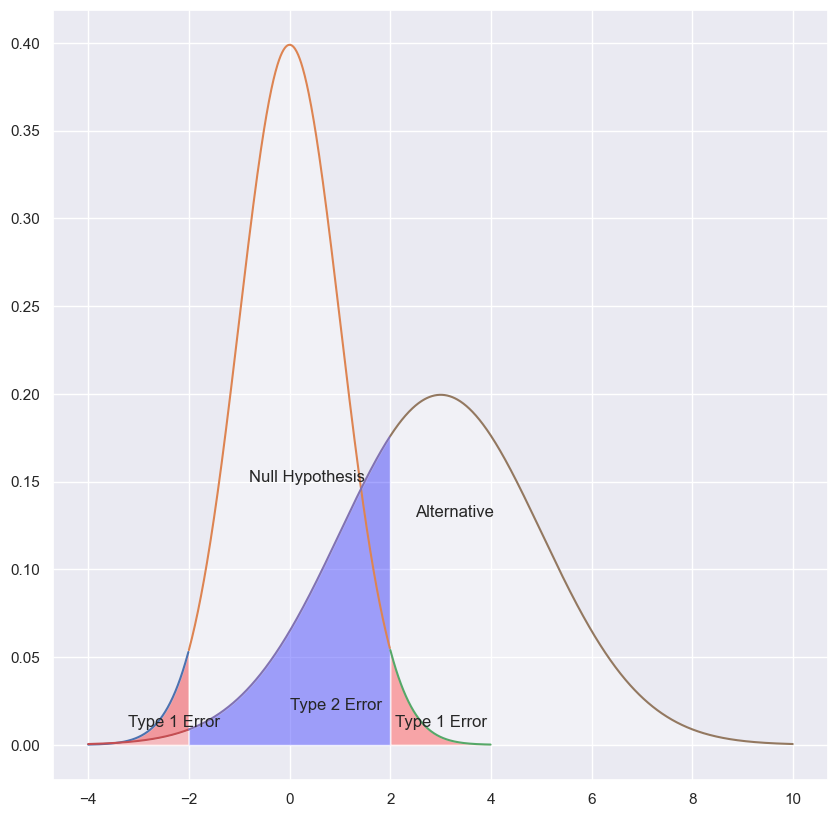

In [14]:
# plt.figure(figsize=(12,10))
plt.plot(np.arange(-4,-2,0.01), stats.norm.pdf(np.arange(-4,-2,0.01)))
plt.fill_between(x=np.arange(-4,-2,0.01),
                 y1=stats.norm.pdf(np.arange(-4,-2,0.01)),
                 facecolor='red',
                 alpha=0.35)

plt.plot(np.arange(-2,2,0.01), stats.norm.pdf(np.arange(-2,2,0.01)))
plt.fill_between(x=np.arange(-2,2,0.01),
                 y1=stats.norm.pdf(np.arange(-2,2,0.01)),
                 facecolor='white',
                 alpha=0.35)

plt.plot(np.arange(2,4,0.01), stats.norm.pdf(np.arange(2,4,0.01)))
plt.fill_between(x=np.arange(2,4,0.01),
                 y1=stats.norm.pdf(np.arange(2,4,0.01)),
                 facecolor='red',
                 alpha=0.5)

plt.plot(np.arange(-4,-2,0.01), stats.norm.pdf(np.arange(-4,-2,0.01), loc=3, scale=2))
plt.fill_between(x=np.arange(-4,-2,0.01),
                 y1=stats.norm.pdf(np.arange(-4,-2,0.01), loc=3, scale=2),
                 facecolor='white',
                 alpha=0.35)

plt.plot(np.arange(-2,2,0.01), stats.norm.pdf(np.arange(-2,2,0.01), loc=3, scale=2))
plt.fill_between(x=np.arange(-2,2,0.01),
                 y1=stats.norm.pdf(np.arange(-2,2,0.01), loc=3, scale=2),
                 facecolor='blue',
                 alpha=0.35)

plt.plot(np.arange(2,10,0.01), stats.norm.pdf(np.arange(2,10,0.01), loc=3, scale=2))
plt.fill_between(x=np.arange(2,10,0.01),
                 y1=stats.norm.pdf(np.arange(2,10,0.01),loc=3, scale=2),
                 facecolor='white',
                 alpha=0.35)

plt.text(x=-0.8, y=0.15, s="Null Hypothesis")
plt.text(x=2.5, y=0.13, s="Alternative")
plt.text(x=2.1, y=0.01, s="Type 1 Error")
plt.text(x=-3.2, y=0.01, s="Type 1 Error")
plt.text(x=0, y=0.02, s="Type 2 Error")

In the plot above, the red areas indicate type I errors assuming the alternative hypothesis is not different from the null for a two-sided test with a 95% confidence level.

The blue area represents type II errors that occur when the alternative hypothesis is different from the null, as shown by the distribution on the right. Note that the Type II error rate is the area under the alternative distribution within the quantiles determined by the null distribution and the confidence level. We can calculate the type II error rate for the distributions above as follows:

In [15]:
lower_quantile = stats.norm.ppf(0.025)  # Lower cutoff value
upper_quantile = stats.norm.ppf(0.975)  # Upper cutoff value

# Area under alternative, to the left the lower cutoff value
low = stats.norm.cdf(lower_quantile,
                     loc=3,
                     scale=2)

# Area under alternative, to the left the upper cutoff value
high = stats.norm.cdf(upper_quantile,
                      loc=3,
                      scale=2)

# Area under the alternative, between the cutoffs (Type II error)
high-low

0.294956061112323

With the normal distributions above, we'd fail to reject the null hypothesis about 30% of the time because the distributions are close enough together that they have significant overlap.

## Wrap Up
The t-test is a powerful tool for investigating the differences between sample and population means. T-tests operate on numeric variables; in the next lesson, we'll discuss statistical tests for categorical variables.

# How to Perform One Sample & Two Sample Z-Tests in Python

https://en.wikipedia.org/wiki/Z-test

https://ru.wikipedia.org/wiki/Z-%D1%82%D0%B5%D1%81%D1%82

https://www.statology.org/z-test-python/

https://www.educba.com/python-z-test/

The Z test involves determining the P-value and then verifying how close the determined P value is close to the significance value which is considered. Usually, the significance value is around 0.05. The P value stands for the representation of the probability value identified. The probability value mentions on how much possible the determined assumption is a null hypothesis or an alternative hypothesis. So based on the P value determined, the reality of the hypothesis assumption is validated. This is the key process of the Z test.

**When to Perform Z Test in Python?**

* First, the size of the sample used determines when the Z test needs to be performed. This means whenever the size of the sample is larger than 30 records, then the Z test is preferred. So the sample size plays a key in Z test determination. When the number of sample records involved is lesser than 30, then the t-test is preferred over the Z test.
* Every datapoint involved needs to be independent between each other. This means both the datapoints involved in the Z test needs to be self-governing, then the data used must be suitable for the Z test. This is another key functionality for considering the Z test in python.
* The normal distribution of the data is expected. Especially for smaller sample sizes, this needs to be strictly followed. The normal distribution of the sample sizes is a key factor for this Z test selection. When the sample size is greater than 30 records, it can be considered without having the normal distribution in place.
* The method of sampling is another key factor used. This determines how precise the hypothesis is calculated. Here we need to ensure the data selected in the sample is well distributed and randomly selected. So from a large set of population, it is necessary to ensure the data is well shuffled and selected from this large set so that all aspects of the population can be covered in the sample set.

You can use the ztest() function from the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html) package to perform one sample and two sample z-tests in Python.

This function uses the following basic syntax:

**statsmodels.stats.weightstats.ztest(x1, x2=None, value=0)**

where:

* x1: values for the first sample
* x2: values for the second sample (if performing a two sample z-test)
* value: mean under the null (in one sample case) or mean difference (in two sample case)

The following examples shows how to use this function in practice.

## Example 1: One Sample Z-Test in Python

Suppose the IQ in a certain population is normally distributed with a mean of $\mu$ = 100 and standard deviation of $\sigma$ = 15.

A researcher wants to know if a new drug affects IQ levels, so he recruits 20 patients to try it and records their IQ levels.

The following code shows how to perform a one sample z-test in Python to determine if the new drug causes a significant difference in IQ levels:

In [16]:
#enter IQ levels for 20 patients
data = [88, 92, 94, 94, 96, 97, 97, 97, 99, 99,
        105, 109, 109, 109, 110, 112, 112, 113, 114, 115]

#perform one sample z-test
ztest(data, value=100)


(1.5976240527147705, 0.11012667014384259)

The test statistic for the one sample z-test is **1.5976** and the corresponding p-value is **0.1101**.

Since this p-value is not less than **0.05**, we do not have sufficient evidence to reject the null hypothesis. In other words, the new drug does not significantly affect IQ level.

## Example 2: Two Sample Z-Test in Python

Suppose the IQ levels among individuals in two different cities are known to be normally distributed with known standard deviations.

A researcher wants to know if the mean IQ level between individuals in city A and city B are different, so she selects a [simple random sample](https://www.statology.org/sampling-methods/) of  20 individuals from each city and records their IQ levels.

The following code shows how to perform a two sample z-test in Python to determine if the mean IQ level is different between the two cities:

In [17]:
#enter IQ levels for 20 individuals from each city
cityA = [82, 84, 85, 89, 91, 91, 92, 94, 99, 99,
         105, 109, 109, 109, 110, 112, 112, 113, 114, 114]

cityB = [90, 91, 91, 91, 95, 95, 99, 99, 108, 109,
         109, 114, 115, 116, 117, 117, 128, 129, 130, 133]

#perform two sample z-test
ztest(cityA, cityB, value=0)

(-1.9953236073282115, 0.04600759676133208)

The test statistic for the two sample z-test is **-1.9953** and the corresponding p-value is **0.0460**.

Since this p-value is less than **0.05**, we have sufficient evidence to reject the null hypothesis. In other words, the mean IQ level is significantly different between the two cities.

# Homework

You are provided with a small data sample containing the information about the RR Lyrae like stars. There are 4 columns available:

* `Type` - subtype of the star (RRAB or RRC)
* `max` - maximum of the brightness of the star
* `min` - minimum of the brightness of the star
* `Period` - period of the variability, measured in days.

Now: it's known that RRAB stars tend to have a longer periods as well as higher change of the amplitude. You goal is to check this fact and support your argument with a hypothesis testing.

The data is available in `rrlyrae.csv` on Moodle.

**Step 1:** load the dataset.

In [25]:
df = pd.read_csv('rrlyrae.csv')

df.head()

,Type,max,min,Period
0,RRC,13.63,13.99,0.332475
1,RRAB,15.07,16.28,0.485529
2,RRAB,14.89,15.85,0.483849
3,RRAB,12.87,13.98,0.606860
4,RRAB,14.10,14.43,0.710245


**Step 2:** check first 10 rows of the sample.

In [26]:
df.head(10)

,Type,max,min,Period
0,RRC,13.63,13.99,0.332475
1,RRAB,15.07,16.28,0.485529
2,RRAB,14.89,15.85,0.483849
3,RRAB,12.87,13.98,0.606860
4,RRAB,14.10,14.43,0.710245
5,RRAB,14.95,15.80,0.681754
6,RRAB,14.34,15.06,0.427410
7,RRAB,14.68,15.15,0.540640
8,RRC,14.11,14.23,0.337106
9,RRAB,14.72,15.45,0.530470


**Step 3:** compute the amplitude. Notice that the [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) scale is reversed. So, the minumum of the brightness has a larger value of magnitude.

In [32]:
df['amp'] = (df['min'] - df['max'])/2

df.head()

,Type,max,min,Period,amp
0,RRC,13.63,13.99,0.332475,0.180
1,RRAB,15.07,16.28,0.485529,0.605
2,RRAB,14.89,15.85,0.483849,0.480
3,RRAB,12.87,13.98,0.606860,0.555
4,RRAB,14.10,14.43,0.710245,0.165


**Step 4:** plot histograms for amplitude and period. Don't forget to add labels & titles to your histograms.

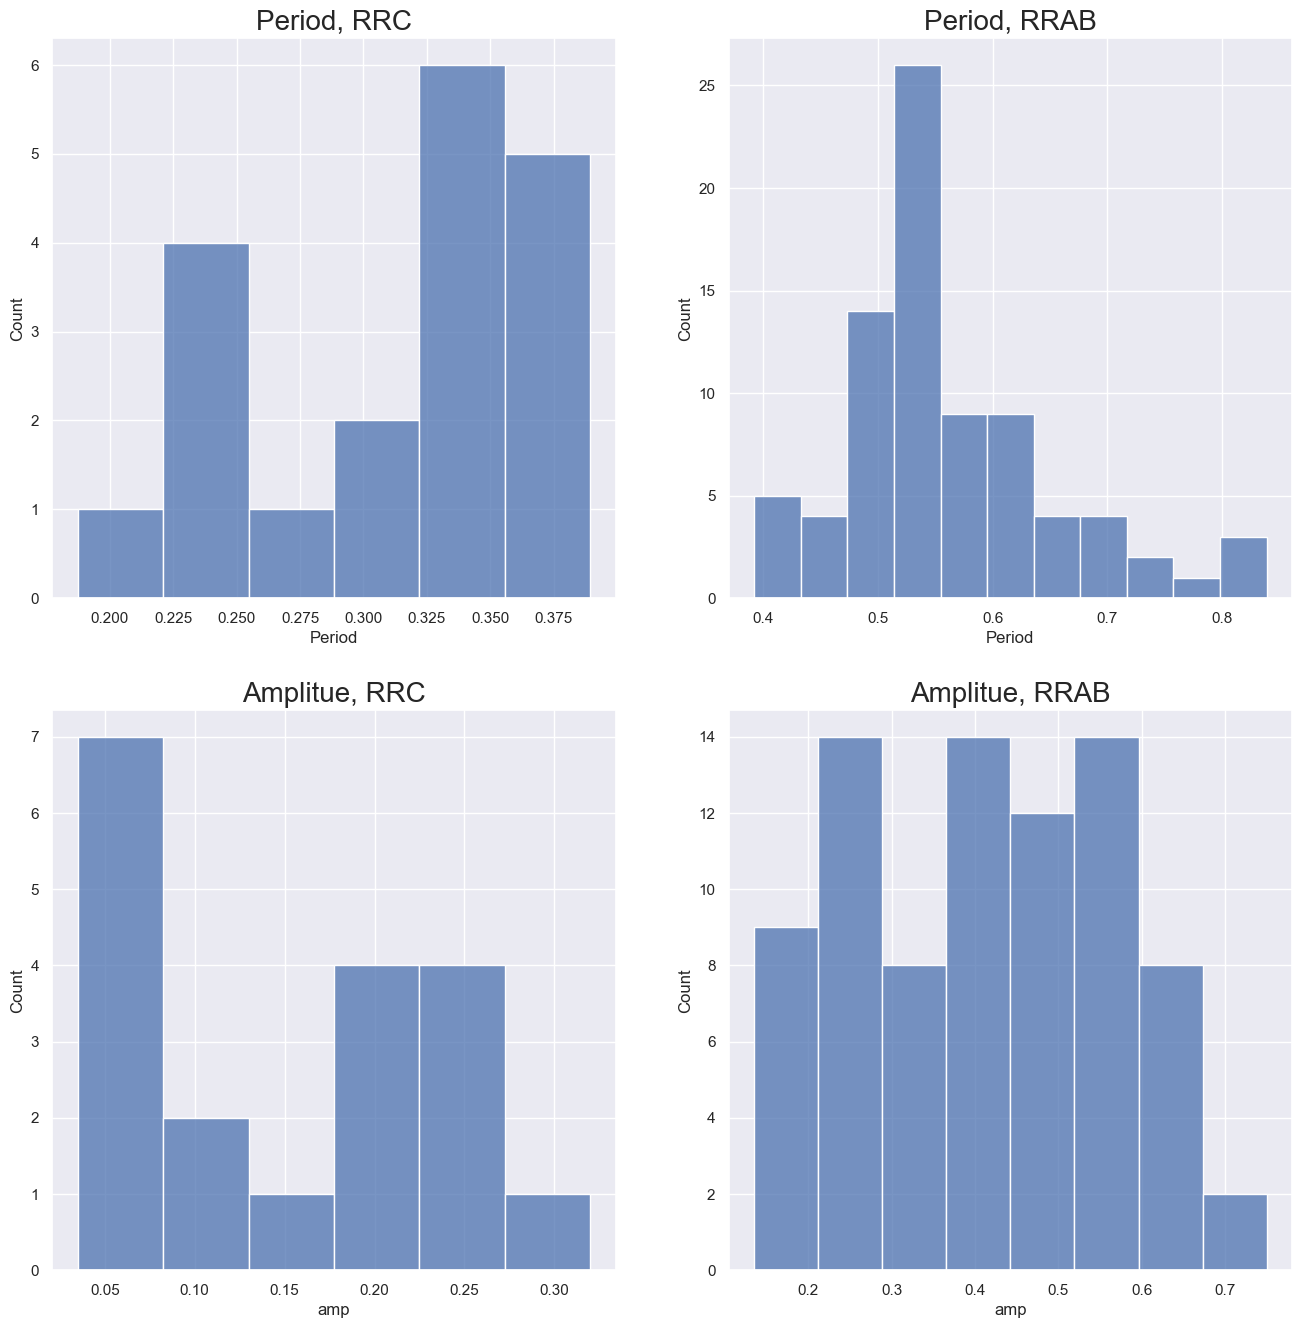

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

for i, star_type in enumerate(df['Type'].unique()):
    axs[0, i].set_title(f"Period, {star_type}", fontsize=20)
    axs[1, i].set_title(f"Amplitue, {star_type}", fontsize=20)

    sns.histplot(df[df['Type'] == star_type], x='Period', ax=axs[0, i])
    sns.histplot(df[df['Type'] == star_type], x='amp', ax=axs[1, i])

***Hint:*** what can you say about the variance in two groups for each parameter?

## Testing Periods

There are two types of the stars:

In [44]:
df["Type"].unique()

array(['RRC', 'RRAB'], dtype=object)

$H_0$: Periods of RRC and RRAB stars have the same mean

$H_1$: Periods of RRC and RRAB stars have significantly different mean


Test your hypothesis using t-test at significance level $\alpha=0.01$.

In [46]:
stats.ttest_ind(a=df[df["Type"] == "RRC"]["Period"],
                b=df[df["Type"] == "RRAB"]["Period"],
                equal_var=False) 

TtestResult(statistic=-14.208392596939989, pvalue=3.813316597745885e-17, df=39.64311496359916)

**Conclusion:** the T-test has shown that different types of stars has different period mean

## Testing amplitudes
Formulate the null and alternative hypothesis:

$H_0$: Amplitured of RRC and RRAB stars have the same mean

$H_1$: Amplitudes of RRC and RRAB stars have significantly different mean

Test your hypothesis using t-test at significance level $\alpha=0.01$.

In [53]:
stats.ttest_ind(a=df[df["Type"] == "RRC"]["amp"],
                b=df[df["Type"] == "RRAB"]["amp"],
                equal_var=False) 

TtestResult(statistic=-9.75126800999531, pvalue=1.046572123187598e-12, df=45.356144593100574)

**Conclusion:** the T-test has shown that different types of stars had different amplitude mean